In [1]:
!pip install llama-index transformers huggingface-hub
!pip install llama-index-llms-huggingface
!pip install llama-index-embeddings-huggingface
!pip install python-dotenv

  Using cached llama_index_agent_openai-0.3.4-py3-none-any.whl.metadata (728 bytes)
  Using cached llama_index_cli-0.3.1-py3-none-any.whl.metadata (1.5 kB)
  Using cached llama_index_embeddings_openai-0.2.5-py3-none-any.whl.metadata (686 bytes)
  Using cached llama_index_legacy-0.9.48.post3-py3-none-any.whl.metadata (8.5 kB)
  Using cached llama_index_program_openai-0.2.0-py3-none-any.whl.metadata (766 bytes)
  Using cached llama_index_question_gen_openai-0.2.0-py3-none-any.whl.metadata (785 bytes)
  Using cached llama_index_readers_file-0.2.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached llama_index_readers_llama_parse-0.3.0-py3-none-any.whl.metadata (3.5 kB)
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached Deprecated-1.2.14-py2.py3-none-any.whl.metadata (5.4 kB)
  Using cached dirtyjson-1.0.8-py3-none-any.whl.metadata (11 kB)
  Using cached pypdf-4.3.1-py3-none-any.whl.metadata (7.4 kB)
  Using cached striprtf-0.0.26-py3-none-any.whl.metadata (2.1 kB)
 

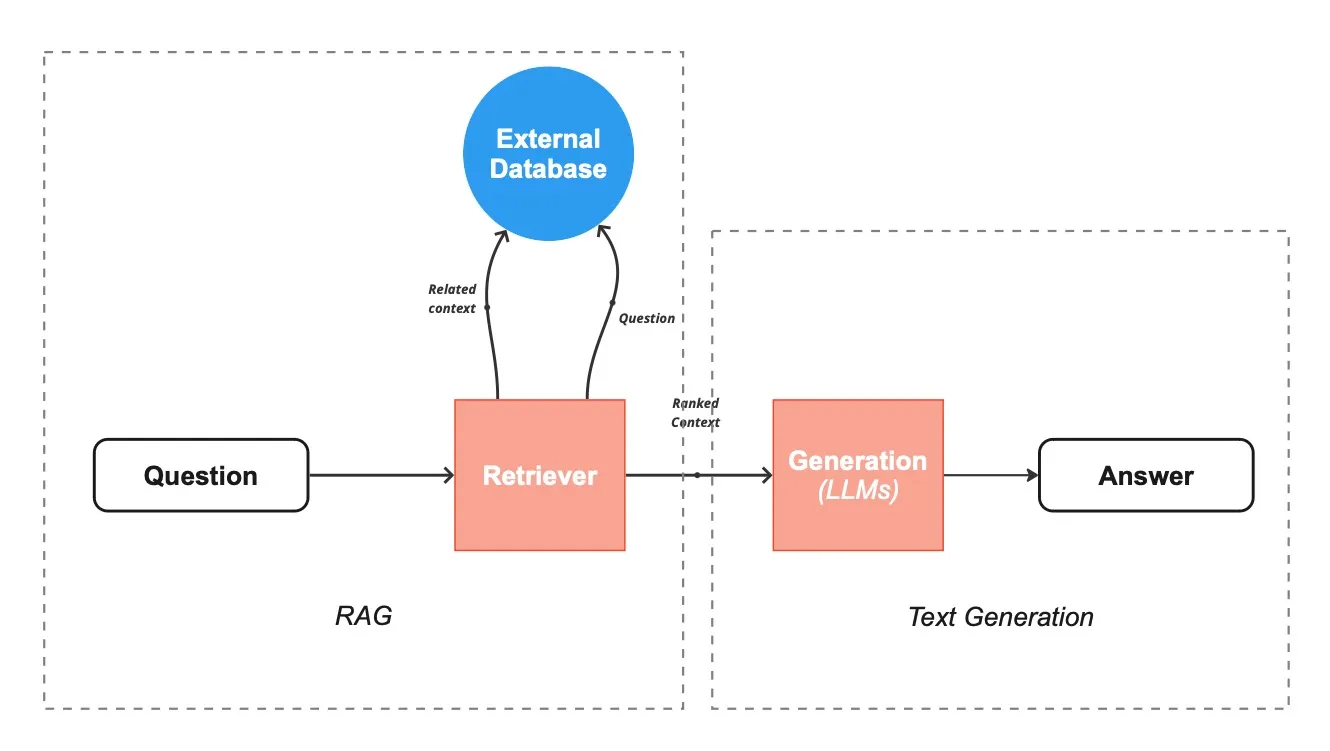

# Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from llama_index.llms.huggingface import HuggingFaceInferenceAPI
from llama_index.core import Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import SimpleDirectoryReader
from llama_index.core import VectorStoreIndex


# Get API token

In [4]:
from dotenv import load_dotenv
import os

In [5]:
load_dotenv('.env')
token = os.getenv('HUGGINGFACEHUB_API_TOKEN')

# Prompt

In [6]:

def completion_to_prompt(completion):
    return f"\n</s>\n\n{completion}</s>\n\n"

def messages_to_prompt(messages):
    prompt = ""
    for message in messages:
        prompt += f"\n{message.content}</s>\n"

    if not prompt.startswith("\n"):
        prompt = "\n</s>\n" + prompt

    prompt = prompt + "\n"
    return prompt

# Set Model and Embeddings

In [7]:
Settings.embed_model = HuggingFaceEmbedding(
    model_name = 'sentence-transformers/all-MiniLM-L6-v2',
)

Settings.llm = HuggingFaceInferenceAPI(
    # model_name="HuggingFaceH4/zephyr-7b-beta",
    model_name="mistralai/Mistral-7B-Instruct-v0.3",
    token=token,
    context_window=3900,
    max_new_tokens=256,
    generate_kwargs={"temperature": 0.7, "top_k": 50, "top_p": 0.95},
    messages_to_prompt=messages_to_prompt,
    completion_to_prompt=completion_to_prompt,
    device_map="auto",
)

C:\Users\Ghost\AppData\Local\Temp\ipykernel_17400\3728232626.py:5: DeprecationWarning: Call to deprecated class HuggingFaceInferenceAPI. (Deprecated in favor of `HuggingFaceInferenceAPI` from `llama-index-llms-huggingface-api` which should be used instead.)
  Settings.llm = HuggingFaceInferenceAPI(


# Load Data

In [8]:
documents = SimpleDirectoryReader('data/pdf2/').load_data()
print(documents)
print(len(documents))
index = VectorStoreIndex.from_documents(documents)

[Document(id_='63190ec4-4c5a-492c-b922-cebd63e3cd17', embedding=None, metadata={'page_label': '1', 'file_name': 'Pengetal.-2018-Uncoveringpatternsoftiesamongregionswithinmetropolitanareasusingdatafrommobilephonesandonlinemassm.pdf', 'file_path': 'd:\\gits\\AI-ML-mentor\\6. Sequence Models\\2.llms\\data\\pdf2\\Pengetal.-2018-Uncoveringpatternsoftiesamongregionswithinmetropolitanareasusingdatafrommobilephonesandonlinemassm.pdf', 'file_type': 'application/pdf', 'file_size': 5096738, 'creation_date': '2024-10-28', 'last_modified_date': '2024-10-28'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text='See discussions, st ats, and author pr ofiles f or this public ation at : https://www .researchgate.ne t/public ation/325129623\nUncovering patterns of ties among 

# Set your RAG based System

In [9]:
query_engine = index.as_query_engine()

# Query Function

In [10]:
def query_llm(query):
    response = query_engine.query(query)
    return response, query

In [11]:
def format_output(answer, query):
    result = f"**Question:** {query}\n\n"
    result += f"**Answer:** \n{answer.response}\n\n"

    if answer.source_nodes:
        result += "You can read more of it at: \n"
        for node in answer.source_nodes:
            # Extracting metadata
            metadata = node.node.metadata
            page = metadata.get('page_label', 'N/A')
            source = metadata.get('file_name', 'N/A')

            # Formatting the source information
            result += f"- Page {page} from {source}\n"
        result += "\n"

    return result

# Query

In [16]:
user_input = "What is the paper about?"

In [17]:
response, query = query_llm(user_input)
formatted_output = format_output(response, query)
print(formatted_output)

**Question:** What is the paper about?

**Answer:** 
The paper is about "Uncovering patterns of ties among regions within metropolitan areas using data from mobile phones and online mass media." This is an article published in the GeoJournal in June 

You can read more of it at: 
- Page 14 from Pengetal.-2018-Uncoveringpatternsoftiesamongregionswithinmetropolitanareasusingdatafrommobilephonesandonlinemassm.pdf
- Page 1 from Pengetal.-2018-Uncoveringpatternsoftiesamongregionswithinmetropolitanareasusingdatafrommobilephonesandonlinemassm.pdf


